In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
# #DATASET --> https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset

df = pd.read_csv('/content/drive/MyDrive/7th SEM Project/training.1600000.Sentiment140.csv', names=['label', 'A', 'X', 'Y', 'Z', 'tweet'], header = None, usecols = ['label', 'tweet'], encoding="ISO-8859-1")

df

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


**FILTERING DATASET START**

In [ ]:
# df = tdf.loc[tdf['tweet'].str.count(' ')<= 40]
# df = tdf.loc[tdf.tweet.str.count(' ')<= 40]

# df

In [ ]:
# df.to_csv('/content/drive/MyDrive/7th SEM Project/Sentiment140_filtered.csv', index = False)

**FILTERING DATASET END**

In [ ]:
df['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [ ]:
import numpy as np

words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, '/content/drive/MyDrive/7th SEM Project/glove.6B.50d.txt')
# words
len(words)

400000

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()

tokenizer.tokenize('@user when a father is dysfunctional and is')
lemmatizer.lemmatize('feet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'foot'

In [ ]:
def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

message_to_token_list('@user ate a fathers is dysfunctional and is')

['user', 'ate', 'a', 'father', 'is', 'dysfunctional', 'and', 'is']

In [ ]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

message_to_word_vectors('@user when a father is dysfunctional and is').shape

(8, 50)

In [ ]:
df = df.sample(frac=1, random_state=1)
df.reset_index(drop=True, inplace=True)

# split_index_1 = int(len(train_df) * 0.7)
# split_index_2 = int(len(train_df) * 0.85)

# train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

# len(train_df), len(val_df), len(test_df)

split_index_1 = int(len(df) * 0.8)

train_df, val_df = df[:split_index_1], df[split_index_1:]

len(train_df), len(val_df)

(1280000, 320000)

In [ ]:
def df_to_X_y(dataframe):
  y = dataframe['label'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dataframe['tweet']:
    message_as_vector_seq = message_to_word_vectors(str(message))
    
    if len(message_as_vector_seq) <= 40:     # ====================================>>>> Filtering out sentences with word count greater than 40
      if message_as_vector_seq.shape[0] == 0:
        message_as_vector_seq = np.zeros(shape=(1, 50))

      all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y

In [ ]:
X_train, y_train = df_to_X_y(train_df)


In [ ]:
print(len(X_train), len(X_train[2]))
print(len(X_train), len(X_train[0]))

1279942 12
1279942 14


(array([1.50965e+05, 2.70001e+05, 2.51076e+05, 2.03463e+05, 1.65907e+05,
        1.41077e+05, 8.14600e+04, 1.51690e+04, 7.66000e+02, 5.80000e+01]),
 array([ 1. ,  4.9,  8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 36.1, 40. ]),
 <BarContainer object of 10 artists>)

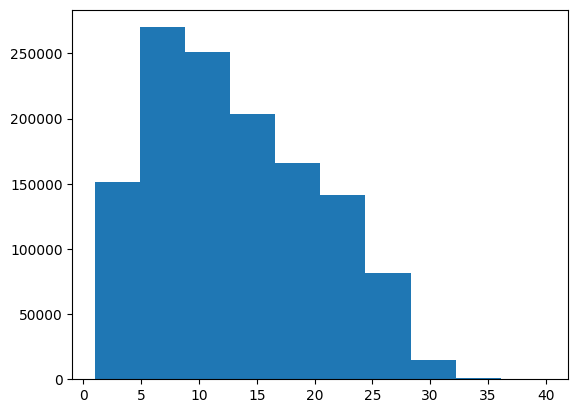

In [ ]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)
# # print(sequence_lengths)
# print(sequence_lengths[:])


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.Series(sequence_lengths).describe()

count   1279942.00
mean         12.97
std           7.20
min           1.00
25%           7.00
50%          12.00
75%          18.00
max          40.00
dtype: float64

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=42):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad_X(X_train)

X_train.shape

In [ ]:
train_df
# train_df[['category']]

,clean_text,category
0,modi has never mention that will give 15lakh h...,-1
1,modi talking about capabilities shooting down ...,1
2,good job ashwin,1
3,for doesnt matter long beloved country grows m...,1
4,modi will give you much place the public you w...,1
...,...,...
114076,former rbi governor raghuram rajan has dropped...,-1
114077,ayurved hospital established dhaulana assembly...,0
114078,why did modi promise then didnt know the rule ...,0
114079,suddenly modi supporters are worried about fis...,0


In [ ]:
# train_df = train_df.astype
# train_dff = train_df.astype(str)
# train_dff
train_df['category'].value_counts()

 1    50536
 0    38842
-1    24703
Name: category, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
y = enc.fit_transform(train_df[['category']])


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# ct = ColumnTransformer([("Country", OneHotEncoder(), [0])], remainder = 'passthrough')
# y = ct.fit_transform(train_df[['category']])

In [ ]:
# y = y.toarray()
import sys
import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
# numpy.set_printoptions(threshold=False)
print(y)

# train_df[['category']].shape
# train_df['category'].value_counts()

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

y1 = enc.fit_transform(val_df[['category']])
X_val.shape, y1.shape

((24446, 52, 50), (24446, 3))

In [ ]:
X_train.shape, y.shape

((114081, 52, 50), (114081, 3))

In [ ]:
# X_test, y_test = df_to_X_y(test_df)
# X_test = pad_X(X_test)

# X_test.shape, y_test.shape

((24447, 50, 50), (24447,))

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([])

model.add(layers.Input(shape=(52, 50)))
# model.add(Dropout(rate=0.2, input_shape=X_train.shape[1:]))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
# model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(3,activation='softmax'))

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

# cp = ModelCheckpoint('model/', save_best_only=True)

# model.compile(optimizer=Adam(learning_rate=0.0001), 
#               loss=BinaryCrossentropy(), 
#               metrics=['accuracy', AUC(name='auc')])
model.compile(loss='categorical_crossentropy', optimizer= Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 52, 64)            29440     
                                                                 
 dropout (Dropout)           (None, 52, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 52, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 52, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 52, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 52, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 3328)             

In [ ]:
#Creating the LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape = (52,50), return_sequences = False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3,activation='softmax')) #Changed 7 to 8 for RAVDESS

# opt = keras.optimizers.RMSprop( learning_rate=0.00005, rho=0.9, epsilon= None)
# model.compile(loss='sparse_categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [ ]:
frequencies = pd.value_counts(train_df['category'])

frequencies

 1.0    50625
 0.0    38754
-1.0    24704
Name: category, dtype: int64

In [ ]:
# weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
# weights

{0: 1.0745917387127761, 1: 14.406310367031551}

In [ ]:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)
model.fit(X_train, y, validation_data=(X_val, y1), epochs=20)

Epoch 1/20
3566/3566 [==============================] - 504s 139ms/step - loss: 0.7535 - accuracy: 0.6672 - val_loss: 0.6360 - val_accuracy: 0.7344
Epoch 2/20
3566/3566 [==============================] - 501s 140ms/step - loss: 0.5495 - accuracy: 0.7812 - val_loss: 0.4727 - val_accuracy: 0.8221
Epoch 3/20
3566/3566 [==============================] - 491s 138ms/step - loss: 0.4297 - accuracy: 0.8416 - val_loss: 0.3833 - val_accuracy: 0.8664
Epoch 4/20
3566/3566 [==============================] - 491s 138ms/step - loss: 0.3556 - accuracy: 0.8740 - val_loss: 0.3380 - val_accuracy: 0.8853
Epoch 5/20
2658/3566 [=====================>........] - ETA: 1:54 - loss: 0.3162 - accuracy: 0.8907

KeyboardInterrupt: ignored

In [ ]:
# from tensorflow.keras.models import load_model

# best_model = load_model('model/')

In [ ]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      4454
           1       0.26      0.80      0.39       341

    accuracy                           0.83      4795
   macro avg       0.62      0.81      0.65      4795
weighted avg       0.93      0.83      0.86      4795

